In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import plotly.express as px
import plotly.graph_objects as go



pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

%load_ext autoreload
%autoreload 2

from collections import defaultdict

from src.utilities.gridSearch import GridSearchEstimators

In [2]:
from sklearn.model_selection       import train_test_split, GridSearchCV
from sklearn.utils                 import resample

from sklearn.ensemble              import RandomForestClassifier, RandomForestRegressor
from sklearn.svm                   import SVC
from sklearn.neighbors             import KNeighborsClassifier
from sklearn.linear_model          import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes           import GaussianNB
from sklearn.ensemble              import AdaBoostClassifier, GradientBoostingClassifier

from sklearn.metrics               import classification_report, f1_score, precision_score, recall_score
from sklearn.metrics               import make_scorer

# Presentation Notebook 1

This notebook is here to summarize our findings for both the feature-engineered ML model and the sparse grades matrix ML model.

The students part of this effort are: Skyler Shi, Danny Ferriss, Mit Kotak, Jarett Brunner, Divya Bhati. \
The instructor of our efforts is: Hannah Christenson.

# Feature-Engineered ML Model

Our initial idea was to engineer several features by intuition and use those features to predict the grades of GIES students. \
These are the features we finally decided to assemble:
- Previous Semester GPA
- Cumulative GPA to date
- Number of Credits to date
- Concentration Cumulative GPA
- Concentration Number of Credits
- Business Core Cumulative GPA
- Business Core Number of Credits
- Prerequisites GPA

In [3]:
ml_df = pd.read_csv('src/data/ml_ready.csv').drop(columns = ['Unnamed: 0'])
ml_df.head()

,EDW_PERS_ID,term_count,Majors_List,Course_name,course_grade,prev_sem_GPA,cum_GPA,num_credits,cum_GPA_concentration,num_credits_concentration,cum_GPA_business_core,num_credits_business_core,prereq_GPA
0,25539,1,Accountancy,BADM 449,B+,3.50,0.00,0.0,0.0,0.0,0.00,0.0,0.0
1,25539,2,Accountancy,ACCY 301,A,3.33,3.33,3.0,0.0,0.0,3.33,3.0,0.0
2,25539,3,Accountancy,ACCY 303,A,4.00,3.67,6.0,4.0,3.0,3.33,3.0,0.0
3,25539,4,Accountancy,ACCY 302,A,4.00,3.78,9.0,4.0,6.0,3.33,3.0,0.0
4,25539,5,Accountancy,ACCY 304,B+,4.00,3.83,12.0,4.0,9.0,3.33,3.0,0.0


## 0. Before we did any modeling, we cleaned up the distribution of grades

We combined honors grades with non-honors grades. For example **"AH"** is combined with **"A"**. We thought this is justifiable because for most classes, most of the coursework of honors students and non-honors students is still the same.

We also dropped grades with rare occurences such as **['W', 'PS', 'ABS', 'AU', 'NR']** because there were too few samples for them to be effectively predicted and they described occurences where the student doesn't finish the class. Whether a student finishes a class is not under our scope of investigation.

In [4]:
def combine_honors_grades(grade):
    if grade[-1] == 'H':
        return grade[0:-1]
    else:
        return grade

ml_df.course_grade = ml_df.course_grade.apply(combine_honors_grades)
ml_df = ml_df[~ml_df.course_grade.isin(['W', 'PS', 'ABS', 'AU', 'NR'])]

In [5]:
features = ['prev_sem_GPA'              ,
            'cum_GPA'                    ,
            'num_credits'                ,
            'cum_GPA_concentration'      ,
            'num_credits_concentration'  ,
            'cum_GPA_business_core'      ,
            'num_credits_business_core'  ,
            'prereq_GPA'                 ]

X = ml_df[features]
y = ml_df['course_grade']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## 1. First, we tried predicting the letter grades.

There were simply too many classes and not enough samples with bad grades for the machine learning model to be accurate.

Below is an example of predictions being run on BADM 300.

In [6]:
# get only samples that are BADM 300
badm300 = ml_df[ml_df.Course_name == "BADM 300"]

# train test split
X = badm300[features]
y = badm300['course_grade']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# fit random forest classifier model
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
predictions = rfc.predict(X_test)
print(classification_report(y_test, predictions, zero_division = 0))

              precision    recall  f1-score   support

           A       0.33      0.56      0.42       185
          A+       0.35      0.29      0.32       117
          A-       0.12      0.10      0.11       103
           B       0.18      0.20      0.19       110
          B+       0.14      0.13      0.14        67
          B-       0.00      0.00      0.00        52
           C       0.09      0.06      0.07        33
          C+       0.07      0.03      0.04        35
          C-       0.00      0.00      0.00        17
           D       0.00      0.00      0.00         8
          D+       0.00      0.00      0.00         4
          D-       0.00      0.00      0.00         1
           F       0.00      0.00      0.00         4

    accuracy                           0.25       736
   macro avg       0.10      0.11      0.10       736
weighted avg       0.20      0.25      0.22       736



## 2. Seeing the results, we decided to predict the Grades Bucketed.

We decided to bucket together grades to promote separability within our models.
- **['A+', 'A', 'A-', 'B+', 'B', 'B-']** are deemed **"good"** grades
- **['C+', 'C', 'C-', 'D+', 'D', 'D-', 'F']** are deemed **"bad"** grades

In [7]:
def bucket_grades(x):
    if x in ['A+', 'A', 'A-', 'B+', 'B', 'B-']:
        return "good"
    if x in ['C+', 'C', 'C-', 'D+', 'D', 'D-', 'F']:
        return "bad"

grades_bucketed_df = ml_df.copy(deep = True)
grades_bucketed_df['course_grade'] = grades_bucketed_df['course_grade'].apply(bucket_grades)

In [8]:
grades_bucketed_df.course_grade.value_counts()

good    121342
bad      12053
Name: course_grade, dtype: int64

In [9]:
# get only samples that are BADM 300
badm300 = grades_bucketed_df[grades_bucketed_df.Course_name == "BADM 300"]

# train test split
X = badm300[features]
y = badm300['course_grade']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

With our grades bucketed, we only have to predict two classes - "good grade" and "bad grade". The machine learning model should not choke as much. \
We run a gridsearch on some popular classifiers and track their performance:

In [10]:
models = {
    'RandomForest': RandomForestClassifier(),
    'KNN'         : KNeighborsClassifier(weights = "distance"),
    'SVM'         : SVC(class_weight = "balanced"),
    'NaiveBayes'  : GaussianNB(),
    'AdaBoost'    : AdaBoostClassifier(),
    'GradBoost'   : GradientBoostingClassifier()
    
}

params = {
    'RandomForest': {
    },
    'KNN': {
    },
    'SVM': {   
    },
    'NaiveBayes': {
    },
    'AdaBoost': {
    },
    'GradBoost': {
    }
}

scoring = {
    'precision % (high)': make_scorer(precision_score, pos_label = 'good'),
    'precision % (low)':  make_scorer(precision_score, pos_label = 'bad'),
    'recall % (high)':    make_scorer(recall_score, pos_label = 'good'),
    'recall % (low)':     make_scorer(recall_score, pos_label = 'bad'),
    'f1 % (high)':        make_scorer(f1_score, pos_label = 'good'),
    'f1 % (low)':         make_scorer(f1_score, pos_label = 'bad'),
}
gs = GridSearchEstimators(models = models, params = params, scoring = scoring)
gs.fit(X_train, y_train)
gs.report()

Running GridSearchCV for RandomForest
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    6.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Running GridSearchCV for KNN
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Running GridSearchCV for SVM
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Running GridSearchCV for NaiveBayes
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Running GridSearchCV for AdaBoost
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Running GridSearchCV for GradBoost
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    0.9s finished


,Estimator,Parameters,mean_precision % (high),mean_precision % (low),mean_recall % (high),mean_recall % (low),mean_f1 % (high),mean_f1 % (low)
0,RandomForest,{},0.886,0.5203,0.9738,0.1815,0.9278,0.2688
1,KNN,{},0.8681,0.1475,0.9714,0.0359,0.9168,0.0575
2,SVM,{},0.9199,0.2411,0.7109,0.5959,0.8017,0.3428
3,NaiveBayes,{},0.9003,0.38,0.9158,0.3377,0.908,0.3574
4,AdaBoost,{},0.8872,0.5183,0.973,0.192,0.9281,0.2765
5,GradBoost,{},0.8863,0.5229,0.9738,0.1842,0.928,0.271


Even with grades bucketed into two classes, we observe that for all ML models tried, the metrics for the good grade class are all very high, but the metrics for the bad grade class are all very low. The focus of our ML model should be to accurately predict the bad grade class, as that represents the students at risk.

Hence, we definitely need to improve precision, recall, f1 for the bad grade class.

## 3. We Correct Class Imbalance to Improve Bad Grade Class metrics

Without any sample size correction, ML models are all biased towards predicting good grade class more accurately because that produces the highest overall accuracy. \
We increase the number of bad grade samples to be the same as good grade samples through up-sampling.

In [11]:
badm300 = grades_bucketed_df[grades_bucketed_df.Course_name == "ECON 302"]

In [12]:
# Separate majority and minority classes
grades_good = badm300[badm300.course_grade == "good"]
grades_bad  = badm300[badm300.course_grade == "bad"]
 
# Upsample minority class
badm300_bad_upsampled = resample(grades_bad, 
                                 replace = True,     # sample with replacement
                                 n_samples = badm300.course_grade.value_counts()['good'],    # to match majority class
                                 random_state = 123) # reproducible results
 
# Combine majority class with upsampled minority class
badm300_upsampled = pd.concat([grades_good, badm300_bad_upsampled])
 
# Display new class counts
badm300_upsampled.course_grade.value_counts()

bad     2725
good    2725
Name: course_grade, dtype: int64

In [13]:
# train test split
X = badm300_upsampled[features]
y = badm300_upsampled['course_grade']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [14]:
models = {
    'RandomForest': RandomForestClassifier(),
    'KNN'         : KNeighborsClassifier(weights = "distance"),
    'SVM'         : SVC(class_weight = "balanced"),
    'NaiveBayes'  : GaussianNB(),
    'AdaBoost'    : AdaBoostClassifier(),
    'GradBoost'   : GradientBoostingClassifier()
    
}

params = {
    'RandomForest': {
    },
    'KNN': {
    },
    'SVM': {   
    },
    'NaiveBayes': {
    },
    'AdaBoost': {
    },
    'GradBoost': {
    }
}

scoring = {
    'precision % (high)': make_scorer(precision_score, pos_label = 'good'),
    'precision % (low)':  make_scorer(precision_score, pos_label = 'bad'),
    'recall % (high)':    make_scorer(recall_score, pos_label = 'good'),
    'recall % (low)':     make_scorer(recall_score, pos_label = 'bad'),
    'f1 % (high)':        make_scorer(f1_score, pos_label = 'good'),
    'f1 % (low)':         make_scorer(f1_score, pos_label = 'bad'),
}
gs = GridSearchEstimators(models = models, params = params, scoring = scoring)
gs.fit(X_train, y_train)
report = gs.report()
report

Running GridSearchCV for RandomForest
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Running GridSearchCV for KNN
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Running GridSearchCV for SVM
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Running GridSearchCV for NaiveBayes
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Running GridSearchCV for AdaBoost
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Running GridSearchCV for GradBoost
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    1.2s finished


,Estimator,Parameters,mean_precision % (high),mean_precision % (low),mean_recall % (high),mean_recall % (low),mean_f1 % (high),mean_f1 % (low)
0,RandomForest,{},0.8713,0.8332,0.8217,0.8795,0.8454,0.8555
1,KNN,{},0.8671,0.7325,0.6664,0.8963,0.7509,0.8053
2,SVM,{},0.6719,0.7231,0.7548,0.6342,0.7108,0.6756
3,NaiveBayes,{},0.6869,0.7244,0.7452,0.663,0.7147,0.6921
4,AdaBoost,{},0.7654,0.7373,0.7194,0.7804,0.7413,0.7579
5,GradBoost,{},0.7816,0.7517,0.7346,0.7954,0.7569,0.7726


In [17]:
report['mean_precision % (high)'] = 100* report['mean_precision % (high)']
report['mean_precision % (low)'] = 100* report['mean_precision % (low)']
report['mean_recall % (high)'] = 100* report['mean_recall % (high)']
report['mean_recall % (low)'] = 100* report['mean_recall % (low)']
report['mean_f1 % (high)'] = 100* report['mean_f1 % (high)']
report['mean_f1 % (low)'] = 100* report['mean_f1 % (low)']
report

# dictionary of column colors
coldict = {'mean_precision % (low)':'orange', 'mean_recall % (low)':'orange'}

def highlight_cols(s, coldict):
    if s.name in coldict.keys():
        return ['background-color: {}'.format(coldict[s.name])] * len(s)
    return [''] * len(s)
report.style.apply(highlight_cols, coldict=coldict)



TypeError: 'Styler' object is not subscriptable

These precision, recall and f1 numbers are much better for the bad grade class after correcting for imbalance. \
We are very happy with these results.

## 4. More Tuning

The RandomForest model seems promising. We tune it some more.

After trying more hyperparameters, we don't notice any significant improvements. Using default hyperparameters of Random Forest Classifier is just fine.

In [18]:
models = {
    'RandomForest': RandomForestClassifier(criterion = 'entropy')
}

params = {
    'RandomForest': {
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 20],
        'n_estimators': [100, 50, 200]
    }
}

scoring = {
    'precision (good)': make_scorer(precision_score, pos_label = 'good'),
    'precision (bad)':  make_scorer(precision_score, pos_label = 'bad'),
    'recall (good)':    make_scorer(recall_score, pos_label = 'good'),
    'recall (bad)':     make_scorer(recall_score, pos_label = 'bad'),
    'f1 (good)':        make_scorer(f1_score, pos_label = 'good'),
    'f1 (bad)':         make_scorer(f1_score, pos_label = 'bad'),
}
gs = GridSearchEstimators(models = models, params = params, scoring = scoring)
gs.fit(X_train, y_train)
gs.report()

Running GridSearchCV for RandomForest
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   13.9s


KeyboardInterrupt: 

## 5. Now Let's see how RandomForest Classifier performs on multiple core courses.

The courses examined are either courses that were taken the most throughout 2009 - 2018 or courses that students scored the lowest in. We can easily examine any set of courses GIES wants us to examine too.

As we can see the Random Forest model works well on a variety of courses! For all classes, the Random Forest model is able to predict grades with an accuracy of around 85%.

In [19]:
courses = ['BADM 449','BADM 320','BADM 300','BADM 310','BUS 388','ECON 202','ECON 203','ECON 302', 
           'FIN 221', 'FIN 300', 'ACCY 201', 'ACCY 202'
           ]
course_df = grades_bucketed_df[grades_bucketed_df.Course_name.isin(courses)]
course_df.Course_name.value_counts()

BADM 300    3680
BADM 449    3658
ECON 302    3643
BADM 320    3616
BADM 310    3601
ECON 203    3600
FIN 221     3240
ACCY 201    3155
ACCY 202    3144
BUS 388     2805
ECON 202    2490
FIN 300     1723
Name: Course_name, dtype: int64

In [20]:
from sklearn.metrics import confusion_matrix
bad_grades = 0
bad_grades_f = 0
cf_matrix= 0 
results = defaultdict(list)
cf_matrix = 0
for course in courses:
    course_df = grades_bucketed_df[grades_bucketed_df.Course_name == course]
    
    # Separate majority and minority classes
    grades_good = course_df[course_df.course_grade == "good"]
    grades_bad  = course_df[course_df.course_grade == "bad"]
    bad_grades =  bad_grades + grades_bad.shape[0]
    # Upsample minority class
    course_bad_upsampled = resample(grades_bad, 
                                     replace = True,     # sample with replacement
                                     n_samples = course_df.course_grade.value_counts()['good'],    # to match majority class
                                     random_state = 123) # reproducible results
    bad_grades_f = bad_grades_f + course_bad_upsampled.shape[0]
    # Combine majority class with upsampled minority class
    course_upsampled = pd.concat([grades_good, course_bad_upsampled])
    # train test split
    X = course_upsampled[features]
    y = course_upsampled['course_grade']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    
    
    # train course RFC model
    rfc = RandomForestClassifier(criterion = 'entropy', random_state = 42)
    
    rfc.fit(X_train, y_train)
    pred = rfc.predict(X_test)
    class_results = classification_report(y_test, pred, output_dict = True)
    results['Course'].append(course)
    for label, d in class_results.items():
        if label in ['macro avg', 'weighted avg']:
            continue
        if label == 'accuracy':
            results['accuracy'].append(class_results['accuracy'])
            continue
        for metric, val in d.items():
            results[(label, metric)].append(val)
    if course=='BADM 310':
        cf_matrix = confusion_matrix(y_test,pred)

multiIdxCols = [v for v in results.keys() if v not in ['Course', 'accuracy']]
cols = pd.MultiIndex.from_tuples(multiIdxCols)
res = pd.DataFrame(results, columns = cols, index = results['Course'])
print(bad_grades,bad_grades_f)

5819 32536


<AxesSubplot:>

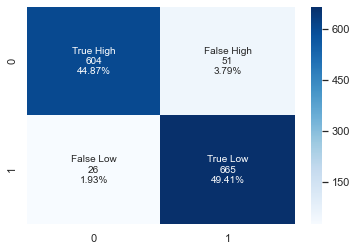

In [28]:
# labels = ['True High','False High','False Low','True Low']
# labels = np.asarray(labels).reshape(2,2)
# sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
group_names = ['True High','False High','False Low','True Low']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

# Sparse Matrix Classification Model

Another approach we attempted was the sparse matrix classification model. In this approach, there are thousands of features. Each feature represents a course and is numeric grade of the student who took the course. If the student has not taken the course, the numeric grade of the student is. 0.0 (hence the sparseness of the matrix).

We assume that having taken courses gives the student knowledge that contributes to their success in taking a specific course. Their grade in that course is a proxy for their mastery of the material. The higher the grade, the better their mastery.

The code for assembling the sparse matrices is computationally intensive and therefore omitted in this notebook. We directly read in the sparse matrices from pickle files. See `assemble_ml_dataf.ipynb` for code on assembling these sparse matrices. 